In [1]:
import sys
sys.path.append("../../")
import numpy as np
from matplotlib import pyplot as plt
import json
import pickle
import os
import torch
from rnn_coach.src.RNN_torch import *
from rnn_coach.src.DynamicSystemAnalyzer import *
from rnn_coach.src.RNN_numpy import *
from rnn_coach.src.Task import *
from rnn_coach.src.DataSaver import *
from latent_circuit_inference.src.LatentCircuit import *
from latent_circuit_inference.src.LatentCircuitFitter import *
from latent_circuit_inference.src.LCAnalyzer import *
from latent_circuit_inference.src.utils import *
from latent_circuit_inference.src.circuit_vizualization import *
import time

def mse_scoring(x, y):
    return np.mean((x - y) ** 2)

def R2(x, y):
    return 1.0 - mse_scoring(x, y)/np.var(y)

In [2]:
#given the folder, open up the files:
RNN_folder = "exemplar_RNN"
tag = '8-nodes'
RNN_folder_full_path = os.path.join("../", "../", "rnn_coach", "data", "trained_RNNs", "CDDM", RNN_folder)
mse_score_RNN = os.listdir(RNN_folder_full_path)[0].split("_")[0]
rnn_data = pickle.load(open(os.path.join(RNN_folder_full_path, os.listdir(RNN_folder_full_path)[0]), "rb+"))

# Latent Circuit Inference set up

In [3]:
LCI_config_file = json.load(open(os.path.join("../", "data", "configs", f"LCI_config.json"), mode="r", encoding='utf-8'))
n_steps = 750
coherence_lvls = 5
n_inputs = 6
n_outputs = 2
max_coherence = 0.8
task_data =  {"cue_on": 0, "cue_off": n_steps,
               "stim_on": int(n_steps // 3), "stim_off": n_steps,
               "dec_on": int(2 * n_steps // 3), "dec_off": n_steps,
               "n_steps": n_steps, "n_inputs": n_inputs, "n_outputs": n_outputs}
tmp = max_coherence * np.logspace(-(coherence_lvls - 1), 0, coherence_lvls, base=2)
coherences = np.concatenate([-np.array(tmp[::-1]), np.array([0]), np.array(tmp)]).tolist()
task_data["coherences"] = coherences
mask = np.concatenate([np.arange(int(n_steps // 3)), int(2 * n_steps // 3) + np.arange(int(n_steps // 3))])
task_data["mask"] = mask

In [4]:
# defining RNN:
activation_name = 'relu'
RNN_N = 100
activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
dt = 1
tau = 10
connectivity_density_rec = 1
spectral_rad = 1.0
sigma_inp = 0.03
sigma_rec = 0.03
seed = np.random.randint(1000000)
print(f"seed: {seed}")
task_data["seed"] = seed
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device('cpu'))
if not seed is None:
    rng.manual_seed(seed)
input_size = np.array(rnn_data["W_inp"]).shape[1]
output_size = np.array(rnn_data["W_out"]).shape[0]


seed: 45229


In [5]:
# Task:
n_steps = task_data["n_steps"]

In [6]:
# LC
n = LCI_config_file["n"]
LC_N = LCI_config_file["N"]
W_inp = np.array(LCI_config_file["W_inp"])
W_out = np.array(LCI_config_file["W_out"])
# Fitter:
lambda_w = 0.02 # LCI_config_file["lambda_w"]
max_iter = 1000 # LCI_config_file["max_iter"]
tol = LCI_config_file["tol"]
lr = 0.03 #LCI_config_file["lr"]
actvation_name = LCI_config_file["activation"]
inp_connectivity_mask = np.array(LCI_config_file["inp_connectivity_mask"])
rec_connectivity_mask = np.array(LCI_config_file["rec_connectivity_mask"])
out_connectivity_mask = np.array(LCI_config_file["out_connectivity_mask"])
if activation_name == 'relu':
    activation_LC = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation_LC = torch.tanh
elif activation_name == 'sigmoid':
    activation_LC = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation_LC = lambda x: torch.log(1 + torch.exp(5 * x))

In [7]:
# # creating instances:
rnn_torch = RNN_torch(N=RNN_N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation_RNN, random_generator=rng, device=device)
RNN_params = {"W_inp":np.array(rnn_data["W_inp"]),
              "W_rec":np.array(rnn_data["W_rec"]),
              "W_out":np.array(rnn_data["W_out"]),
              "b_rec":np.array(rnn_data["bias_rec"]),
              "y_init":np.zeros(RNN_N)}
rnn_torch.set_params(RNN_params)

lc = LatentCircuit(n=n,
                   N=LC_N,
                   W_inp=torch.Tensor(W_inp),
                   W_out=torch.Tensor(W_out),
                   inp_connectivity_mask=inp_connectivity_mask,
                   rec_connectivity_mask=rec_connectivity_mask,
                   out_connectivity_mask=out_connectivity_mask,
                   activation=activation_LC,
                   device=device,
                   sigma_rec = 0.03, 
                   sigma_inp = 0.03, 
                   random_generator=rng)

task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_data)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lc.parameters(), lr=lr)
fitter = LatentCircuitFitter(LatentCircuit=lc, RNN=rnn_torch, Task=task,
                             max_iter=max_iter, tol=tol,
                             optimizer=optimizer, criterion=criterion,
                             lambda_w=lambda_w)



Using cpu for RNN!
Using cpu for Latent Circuit!


In [8]:
tic = time.perf_counter()
lc_inferred, train_losses, val_losses, net_params = fitter.run_training()
toc = time.perf_counter()
print(f"Executed training in {toc - tic:0.4f} seconds")

cpu cpu cpu


KeyboardInterrupt: 

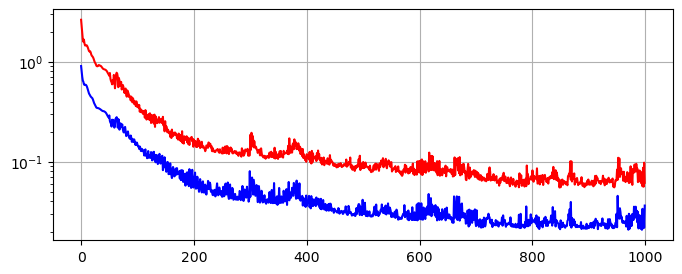

In [9]:
fig_losses = plt.figure(figsize=(8, 3))
plt.plot(train_losses, color = 'r', scaley='semilog')
plt.plot(val_losses, color = 'b', scaley='semilog')
plt.grid(True)
plt.yscale("log")
plt.show()

In [10]:
# # save the data so that you dont do it again!
# file = f'LCI_data_example.pkl'
# pickle.dump(net_params, open(os.path.join("./", file), 'wb+'))

In [9]:
file = f'LCI_data_example.pkl'
net_params = pickle.load(open(os.path.join("./", file), 'rb+'))

In [10]:
# defining circuit
n = LCI_config_file["n"]
U = net_params["U"]
q = net_params["q"]
Q = q @ U
W_rec = RNN_params["W_rec"]
w_rec_bar = Q @ W_rec @ Q.T
w_rec = net_params["W_rec"]
names = ["ctx m", "ctx c", "mr", "ml", "cr", "cl", "OutR", "OutL"]
w_rec = net_params["W_rec"]
w_inp = net_params["W_inp"]
w_out = net_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]
activation_fun_circuit = lambda x: np.maximum(0, x)
circuit = RNN_numpy(N=n, W_rec=w_rec, W_inp=w_inp, W_out=w_out, dt=dt, tau=tau, activation=activation_fun_circuit)
circuit.y = np.zeros(n)

In [11]:
# defining RNN
N = rnn_data["N"]
x = np.random.randn(n)
W_rec = RNN_params["W_rec"]
W_inp = RNN_params["W_inp"]
W_out = RNN_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]
activation_fun_RNN = lambda x: np.maximum(0, x)
RNN = RNN_numpy(N=N, W_rec=W_rec, W_inp=W_inp, W_out=W_out, dt=dt, tau=tau, activation=activation_fun_RNN)
RNN.y = np.zeros(n)

In [27]:
# defining analyzer
node_labels = ['ctx m', "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"]
analyzer = LCAnalyzer(circuit, labels=node_labels)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()


In [28]:
#MSE mse_score_RNN
score_function = lambda x, y: np.mean((x - y) ** 2)
mse_score = analyzer.get_validation_score(scoring_function=mse_scoring,
                                          input_batch=input_batch_valid,
                                          target_batch=target_batch_valid,
                                          mask=mask,
                                          sigma_rec=0,
                                          sigma_inp=0)
mse_score = np.round(mse_score, 8)
print(f"MSE: {mse_score}")

MSE: 0.00934177


In [14]:
# Total variance
batch_size = input_batch_valid.shape[2]
RNN.clear_history()
circuit.clear_history()
RNN_trajectories, RNN_output = RNN.run_multiple_trajectories(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
lc_trajectories, lc_output = circuit.run_multiple_trajectories(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)

In [15]:
lc_trajectories_emb = np.swapaxes(Q.T @ np.swapaxes(lc_trajectories, 0, 1), 0, 1)
RNN_trajectories_proj = np.swapaxes(Q @ np.swapaxes(RNN_trajectories, 0, 1), 0, 1)
r2_tot = np.mean([R2(lc_trajectories_emb[:, mask, i], RNN_trajectories[:, mask, i]) for i in range(batch_size)])
r2_proj = np.mean([R2(lc_trajectories[:, mask, i], RNN_trajectories_proj[:, mask, i]) for i in range(batch_size)])
print(f"Total R2: {r2_tot}")
print(f"Projected R2: {r2_proj}")
scores = {"mse_score": mse_score, "r2_tot":r2_tot, "r2_proj" : r2_proj}

Total R2: 0.8998594656658585
Projected R2: 0.9691668000189317


In [16]:
# data_folder = os.path.join(LCI_config_file["data_folder"], RNN_folder, f"{mse_score}_LC_{tag}")
# datasaver = DataSaver(data_folder)
# datasaver.save_data(scores, f"{mse_score}_LC_scores.pkl")
# datasaver.save_data(LCI_config_file, f"{mse_score}_LC_config.json")
# datasaver.save_data(net_params, f"{mse_score}_LC_params.pkl")

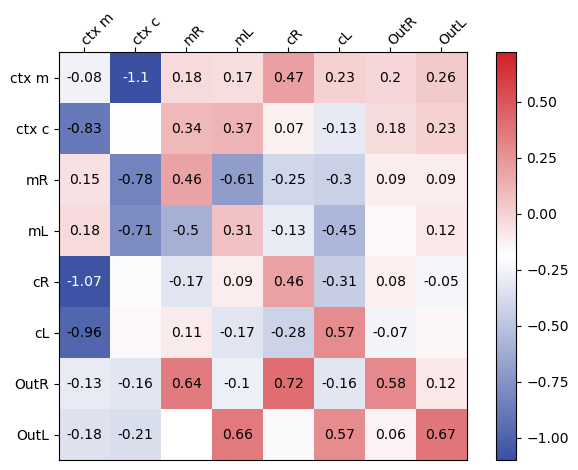

In [17]:
w_rec = net_params["W_rec"]
fig_w_rec = analyzer.plot_recurrent_matrix()
# datasaver.save_figure(fig_w_rec, f"{mse_score}_LC_wrec.png")
plt.show()

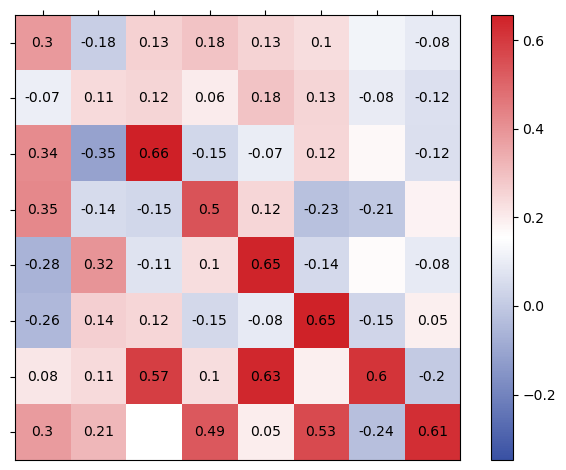

In [18]:
def plot_recurrent_matrix(w_rec):
    fig_w_rec = plt.figure()
    ax = plt.gca()
    labels = []
    im = ax.imshow(w_rec, interpolation='blackman', cmap=cmap)
    fig_w_rec.colorbar(im)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(labels)
    ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
    plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="right", va="center", rotation_mode="anchor")
    plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="left", va="center", rotation_mode="anchor")

    for (i, j), z in np.ndenumerate(w_rec):
        if np.abs(z) >= 0.05:
            if z >= -1:
                ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
            if z < -1:
                ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
    # ax.set_title("Connectivity matrix", fontsize = 16, pad=10)
    im = ax.imshow(w_rec, interpolation='none', vmin=-np.max(np.abs(w_rec)), vmax=np.max(np.abs(w_rec)), cmap=cmap)
    fig_w_rec.tight_layout()
    return fig_w_rec

fig_w_rec = plot_recurrent_matrix(w_rec_bar)
plt.show()

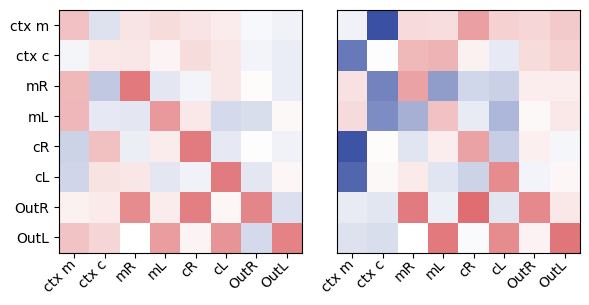

In [19]:
fig_w_rec_comparison = analyzer.plot_recurrent_matrix_comparison(w_rec_bar=w_rec_bar)
# datasaver.save_figure(fig_w_rec_comparison, f"{mse_score}_LC_wrec_comparison.png")
plt.show()

Plotting random trials


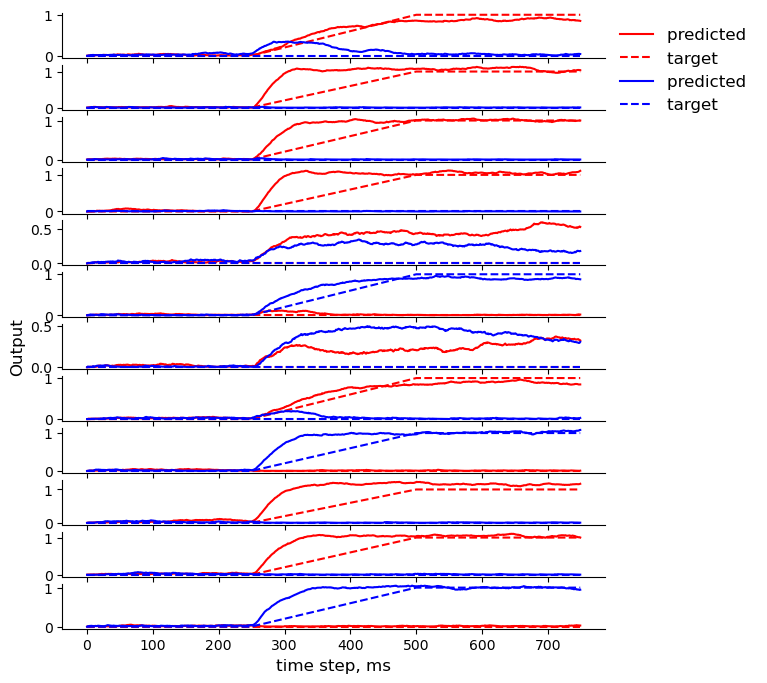

In [20]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
# datasaver.save_figure(fig_trials, f"{mse_score}_LC_random_trials.png")
plt.show()

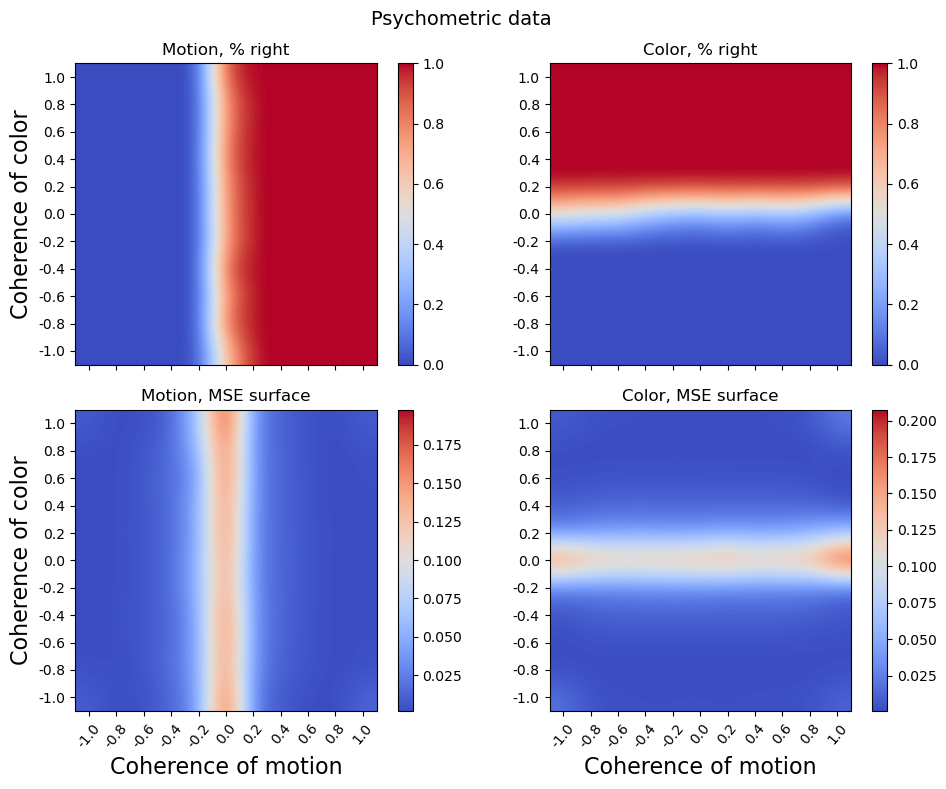

In [20]:
num_levels = len(task_data["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
# datasaver.save_figure(fig_psycho, f"{mse_score}_LC_psychometric.png")
# datasaver.save_data(analyzer.psychometric_data, f"{mse_score}_psycho_data.pkl")
plt.show()

Analyzing fixed points
Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

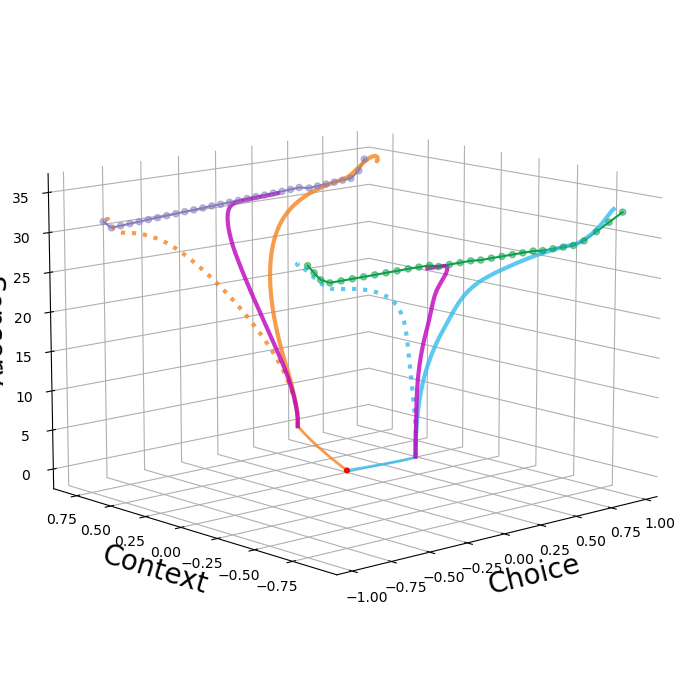

In [21]:
print(f"Analyzing fixed points")
dsa = DynamicSystemAnalyzerCDDM(circuit)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 15,
          "patience": 100,
          "stop_length": 100,
          "mode": "approx"}
dsa.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
print(f"Calculating Line Attractor analytics")
dsa.calc_LineAttractor_analytics()
fig_LA3D = dsa.plot_LineAttractor_3D()
# datasaver.save_figure(fig_LA3D, f"{mse_score}_LC_LA3D.png")
# datasaver.save_data(dsa.fp_data, f"{mse_score}_fp_data.pkl")
# datasaver.save_data(dsa.LA_data, f"{mse_score}_LA_data.pkl")
plt.show()

In [22]:
LA_data_lc = pickle.load(open(os.path.join(data_folder, f"{mse_score}_LA_data.pkl"), "rb+"))
LA_data_RNN = pickle.load(open(os.path.join(RNN_folder_full_path, f"{mse_score_RNN}_LA_data.pkl"), "rb+"))
fig_selection_vects = analyzer.plot_selection_vectors(Q, LA_data_lc, LA_data_RNN)
# datasaver.save_figure(fig_selection_vects, f"{mse_score}_selection_vects_comparison.png")
plt.show()

NameError: name 'data_folder' is not defined

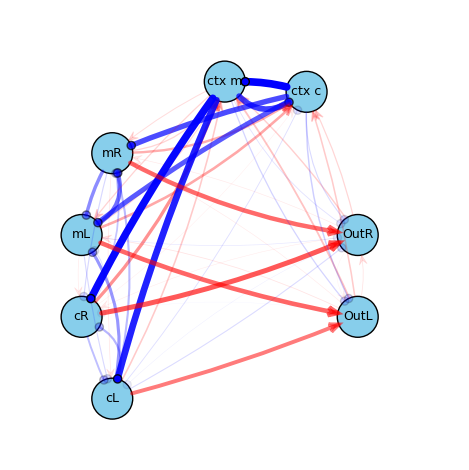

In [26]:
fig_circuit_graph = analyzer.plot_circuit_graph()
# datasaver.save_figure(fig_circuit_graph, f"{mse_score}_circuit_graph.png")
plt.show()